### temp를 PCA로 통합해 분석해보자

In [1]:
# load Data
import pandas as pd
import numpy as np

data = pd.read_csv('../DATA/train_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200159 entries, 0 to 200158
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   c_temp_pv  200159 non-null  float64
 1   k_rpm_pv   200159 non-null  int64  
 2   n_temp_pv  200159 non-null  float64
 3   scale_pv   200159 non-null  float64
 4   s_temp_pv  200159 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 7.6 MB


In [2]:
# Data Preprocessing
# 2 < scale_pv < 4
data = data[(data['scale_pv'] > 2) & (data['scale_pv'] < 4)]

# PCA 분석
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA 분석을 위한 데이터 준비
X = data.drop(['scale_pv', 'k_rpm_pv'], axis=1)

# 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# PCA 분석
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)

# PCA 결과
print('PCA Component Shape:', X_pca.shape)
print('PCA Component:', pca.components_)
print('PCA Explained Variance:', pca.explained_variance_ratio_)
print('PCA Explained Variance Sum:', sum(pca.explained_variance_ratio_))


PCA Component Shape: (36720, 1)
PCA Component: [[0.37016399 0.67372249 0.63959098]]
PCA Explained Variance: [0.56120402]
PCA Explained Variance Sum: 0.5612040219602998


In [3]:
# PCA 결과를 데이터프레임에 추가
data['PCA'] = X_pca
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36720 entries, 0 to 200107
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   c_temp_pv  36720 non-null  float64
 1   k_rpm_pv   36720 non-null  int64  
 2   n_temp_pv  36720 non-null  float64
 3   scale_pv   36720 non-null  float64
 4   s_temp_pv  36720 non-null  float64
 5   PCA        36720 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 2.0 MB


In [4]:
# Random Forest without PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

X = data.drop(['scale_pv', 'PCA'], axis=1)
y = data['scale_pv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Random Forest without PCA')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred)*100)
print('R2:', r2_score(y_test, y_pred))


Random Forest without PCA
MAE: 0.020739688478127995
MAPE: 0.6832850969599515
R2: 0.4061375618241577


In [5]:
 # 편차의 descriptives
diff = y_test.values - y_pred
diff = pd.Series(diff)
diff.describe()

count    7344.000000
mean       -0.000161
std         0.031541
min        -0.414400
25%        -0.013806
50%         0.000400
75%         0.014475
max         0.307467
dtype: float64

In [6]:
# Random Forest 모델 학습
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# feature : PCA, k_rpm_pv
# target : scale_pv
X = data[['PCA', 'k_rpm_pv']]
y = data['scale_pv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)    # 200개일때가 더 크다
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred)*100)
print('R2:', r2_score(y_test, y_pred))

MAE: 0.027692902530646185
MAPE: 0.9131137571869419
R2: -0.017669738516535638


In [7]:
# n_estimators=100일때와 200일때랑 비슷하다
# PCA를 사용하면 더 성능이 떨어진다... 잠정 보류

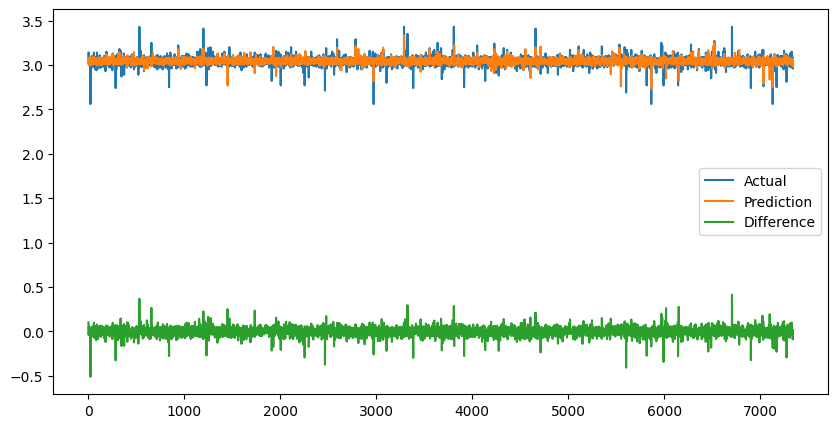

In [8]:
# 실제값과 예측값의 편차 비교
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Prediction')
plt.plot(y_test.values - y_pred, label='Difference')
plt.legend()
plt.show()

In [9]:
 # 편차의 descriptives
diff = y_test.values - y_pred
diff = pd.Series(diff)
diff.describe()

count    7344.000000
mean       -0.000987
std         0.041277
min        -0.510600
25%        -0.020554
50%         0.000133
75%         0.019500
max         0.412600
dtype: float64

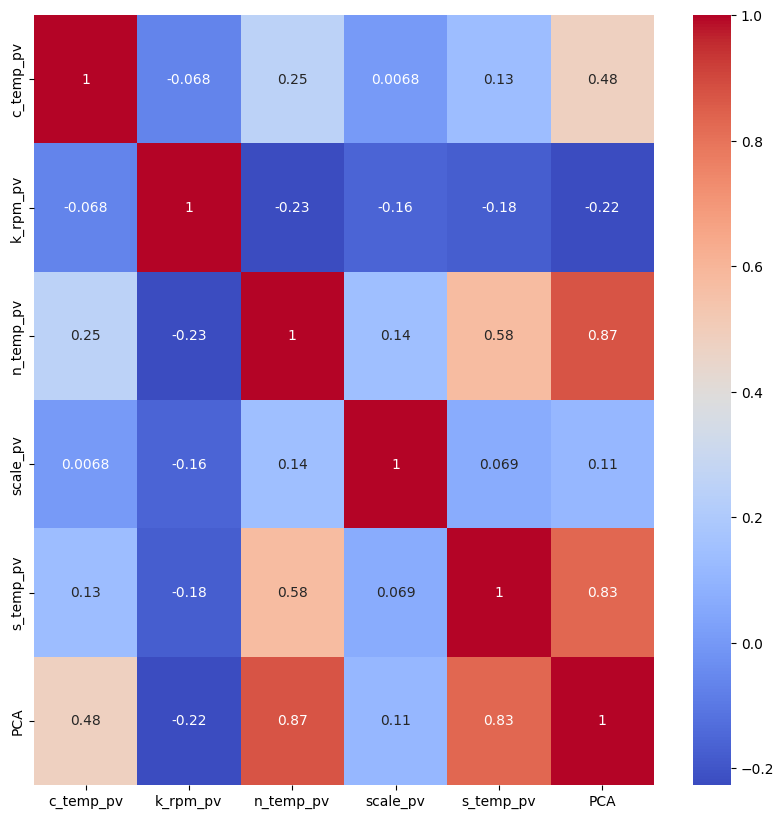

In [10]:
# corr heatmap
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()